In [1]:
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from PIL import Image
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, MaxPool2D, GlobalAveragePooling2D, Reshape, Lambda, GlobalMaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from scipy.spatial import distance
import tensorflow.keras.backend
import seaborn as sns
from keras.regularizers import l2

In [2]:
#creating train images and labelsdata set
train_csv = pd.read_csv("Data\\humpback-whale-identification\\train_small.csv")
train_data = train_csv.values.tolist()

#create dict for train image names and labels
train_image_names = {}
for el in train_data:
    img_name = el[0]
    train_label = el[1]
    if train_label != 'new_whale':
        train_image_names[img_name] = train_label
        
train_images = []
train_labels = []

#loading images from folder and turning to array
for img in train_image_names.keys():
    f_name = r'Data\\humpback-whale-identification\\train_resized_128\\' + img
    train_image = np.asarray(Image.open(f_name))
    train_images.append(train_image)
    train_labels.append(train_image_names[img])

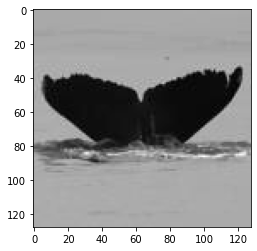

In [3]:
plt.imshow(train_images[250], cmap = 'gray')

In [4]:
#turning train data lists --> reshaped and normalized np.arrays

train_images = np.reshape(np.array(train_images), (len(train_images), 128, 128, 1)) / 255
train_labels = np.reshape(np.array(train_labels), (len(train_labels), 1))

train_images.shape, train_labels.shape

((3612, 128, 128, 1), (3612, 1))

In [5]:
#function for shuffling data

def shuffle_in_unison(a, b):
    n_elem = a.shape[0]
    indeces = np.random.choice(n_elem, size=n_elem, replace=False)
    return a[indeces], b[indeces]

train_images_sh, train_labels_sh = shuffle_in_unison(train_images, train_labels)
train_images_sh.shape, train_labels_sh.shape

((3612, 128, 128, 1), (3612, 1))

In [6]:
random.seed(0)
#creating similar pairs

uniques = np.unique(train_labels_sh) #array of unique labels

similar_X = []
similar_Y = []

for el in uniques:
    index = np.where(train_labels_sh == el)[0] #getting indexes of each unique in train_labels_sh
    for i in range(0,6,2): #6 because there are 6 images of each label
        pair = []
        image_one = train_images_sh[index[i]]
        image_two = train_images_sh[index[i+1]]
        pair.append(image_one)
        pair.append(image_two)
        similar_X.append(pair)
        similar_Y.append(1)

similar_X = np.array(similar_X)
similar_Y = np.array(similar_Y)

#creating different pairs

different_X = []
different_Y = []

help_list = list(range(int(len(train_images_sh)/2), int(len(train_images_sh)))) #help list to get images from the second half

for i in range(int(len(train_images_sh)/2)): #looping through the first half of the train mages
    pair = []
    image_one = train_images_sh[i]
    random_no = random.choice(help_list)
    image_two = train_images_sh[random_no]
    if train_labels_sh[i] == train_labels_sh[random_no]: #if labels match, goes back to find a new one
        i = i - 1
        pass
    pair.append(image_one)
    pair.append(image_two)
    different_X.append(pair)
    different_Y.append(0) 
    help_list.remove(random_no)

different_X = np.array(different_X)
different_Y = np.array(different_Y)

similar_X.shape, different_X.shape, similar_Y.shape, different_Y.shape

((1806, 2, 128, 128, 1), (1806, 2, 128, 128, 1), (1806,), (1806,))

In [7]:
#shuffling similar and different data
similar_X, similar_Y = shuffle_in_unison(similar_X, similar_Y)
different_X, different_Y = shuffle_in_unison(different_X, different_Y)

#creating val set (10% of train set)
val_X = np.concatenate((similar_X[int(len(similar_X)*0.9):], different_X[int(len(different_X)*0.9):]))
val_Y = np.concatenate((similar_Y[int(len(similar_Y)*0.9):], different_Y[int(len(different_Y)*0.9):]))

#excluding val set from similar and different pairs
similar_X, similar_Y = similar_X[:int(len(similar_X)*0.9)], similar_Y[:int(len(similar_Y)*0.9)]
different_X, different_Y = different_X[:int(len(different_X)*0.9)], different_Y[:int(len(different_Y)*0.9)]

#turning similar and different pairs into one array
train_X = np.concatenate((similar_X, different_X))
train_Y = np.reshape(np.concatenate((similar_Y, different_Y)), (len(train_X), 1))
val_Y = np.reshape(val_Y, (len(val_X), 1))

#shuffling once again
train_X, train_Y = shuffle_in_unison(train_X, train_Y)
val_X, val_Y = shuffle_in_unison(val_X, val_Y)

#reshaping labels for model
train_Y = train_Y.reshape((-1,1))
val_Y = val_Y.reshape((-1,1))

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

((3250, 2, 128, 128, 1), (3250, 1), (362, 2, 128, 128, 1), (362, 1))

In [8]:
# amount of unique labels in the train set
len(np.unique(train_labels_sh, return_counts = True)[0])

602

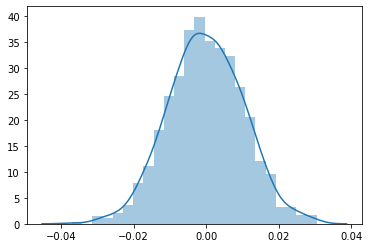

In [9]:
#code taken from https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb
#"The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01"

def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

weights = initialize_weights((1000,1))
sns.distplot(weights)

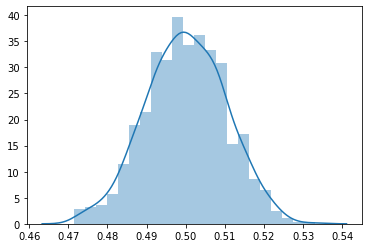

In [10]:
#code taken from https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb
#"The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01"

def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

bias = initialize_bias((1000,1))
sns.distplot(bias)

In [11]:
#defining branch and head model

def get_model(input_shape): 
    
    #branch model
    
    seq_model = Sequential()
    
    seq_model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape,kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    seq_model.add(MaxPooling2D((1, 1)))
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))) 
    seq_model.add(MaxPooling2D((1, 1)))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(64, (3,3), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))   
    seq_model.add(MaxPooling2D((1, 1)))
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(64, (3,3), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))    
    seq_model.add(MaxPooling2D((1, 1)))   
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(128, (3,3), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))    
    seq_model.add(MaxPooling2D((1, 1))) 
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(128, (3,3), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))     
    seq_model.add(MaxPooling2D((2, 2))) 
    seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(256, (1,1), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))  
    #seq_model.add(MaxPooling2D((2,2)))
    #seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(256, (1,1), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))  
    #seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(512, (1,1), activation='relu')) 
    #seq_model.add(BatchNormalization())
    
    seq_model.add(GlobalMaxPooling2D())
    
    seq_model.add(Flatten())
    seq_model.add(Dense(602, activation='sigmoid',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))) 
    
    #head model
    
    in1 = Input(input_shape)
    in2 = Input(input_shape)
    
    out_x1 = seq_model(in1)
    out_x2 = seq_model(in2)
    
    euc_dist = Lambda(lambda tensors:tensorflow.keras.backend.abs(tensors[0] - tensors[1]))([out_x1 , out_x2])
    
    outputs = Dense(1, activation = 'sigmoid', bias_initializer=initialize_bias)(euc_dist)
    
    snn = Model(inputs = [in1, in2], outputs = outputs)
    
    return snn

In [12]:
#create model with necessary input shape, compile

model= get_model((128, 128, 1))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0005), metrics = ['accuracy'])
callback = EarlyStopping(patience = 3, monitor = 'loss', restore_best_weights = True)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 602)          365882      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 602)          0           sequential[0][0]      

In [ ]:
history = model.fit(x = [train_X[:,0], train_X[:,1]], y = train_Y, epochs = 20, batch_size = 64, 
                    validation_data = ([val_X[:,0], val_X[:,1]], val_Y), shuffle=True, callbacks = callback)

In [ ]:
#plot train and validation loss and accuracy (taken from ML HW 3)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [ ]:
model.save('Data\\humpback-whale-identification\\snn_model.hdf5')

In [ ]:
#creating test images data set
test_csv = pd.read_csv("Data\\humpback-whale-identification\\sample_submission.csv")
test_data = test_csv.values.tolist()

test_image_names = []
for el in test_data:
    img_name = el[0]
    test_image_names.append(img_name)

test_images = []
for img in test_image_names:
    f_name = r'Data\\humpback-whale-identification\\test_resized_128\\' + img
    test_image = np.asarray(Image.open(f_name))
    test_images.append(test_image)
        
test_images = np.reshape(np.array(test_images), (len(test_images), 128, 128, 1)) / 255
test_images.shape